In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time

c:\Users\nguye\anaconda3\envs\pytor\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.datasets import MNIST
## Load MNIST Dataset and apply transformations
mnist = MNIST("data", download=True, train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))]))

In [3]:
rawData = DataLoader(mnist, batch_size=10)
dataiter = iter(rawData)
data, labels = dataiter.next()
data = data.view(data.shape[0], -1)

In [4]:
## create training and validation split 
split = int(0.8 * len(mnist))
index_list = list(range(len(mnist)))
train_idx, valid_idx = index_list[:split], index_list[split:]
## create sampler objects using SubsetRandomSampler
tr_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)
## create iterator objects for train and valid datasets
trainloader = DataLoader(mnist, batch_size=256, sampler=tr_sampler)
validloader = DataLoader(mnist, batch_size=256, sampler=val_sampler)

In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(784, 128)
        self.output = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.hidden(x)
        x = F.sigmoid(x)
        x = self.output(x)
        return x

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [7]:
model = Model()
model.to(device)

Model(
  (hidden): Linear(in_features=784, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
)

In [8]:
from torch import optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay= 1e-6, momentum = 0.9, nesterov = True)

In [9]:
import numpy as np

for epoch in range(1, 11): ## run the model for 10 epochs
    train_loss, valid_loss = [], []
    ## training part 
    model.train()
    for data, target in trainloader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        ## 1. forward propagation
        data = data.view(data.shape[0], -1)
        output = model(data)
        
        ## 2. loss calculation
        loss = loss_function(output, target)
        
        ## 3. backward propagation
        loss.backward()
        
        ## 4. weight optimization
        optimizer.step()
        
        train_loss.append(loss.item())
        
    ## evaluation part 
    model.eval()
    for data, target in validloader:
        data = data.to(device)
        target = target.to(device)
        data = data.view(data.shape[0], -1)
        output = model(data)
        loss = loss_function(output, target)
        valid_loss.append(loss.item())
    print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss), "Valid Loss: ", np.mean(valid_loss))

c:\Users\nguye\anaconda3\envs\pytor\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 Training Loss:  1.4383111000061035 Valid Loss:  0.7111203771956424
Epoch: 2 Training Loss:  0.577650359177843 Valid Loss:  0.4458046986701641
Epoch: 3 Training Loss:  0.43225214757183766 Valid Loss:  0.37175066230144904
Epoch: 4 Training Loss:  0.37655952747197863 Valid Loss:  0.33566163987555403
Epoch: 5 Training Loss:  0.3458935962395465 Valid Loss:  0.313830721568554
Epoch: 6 Training Loss:  0.3250329224987233 Valid Loss:  0.2979783149475747
Epoch: 7 Training Loss:  0.3086256218400407 Valid Loss:  0.285921943631578
Epoch: 8 Training Loss:  0.2955181490867696 Valid Loss:  0.27437526494898695
Epoch: 9 Training Loss:  0.2843670953619987 Valid Loss:  0.2674336912150079
Epoch: 10 Training Loss:  0.2739129112438953 Valid Loss:  0.2573731611383722


In [10]:
torch.save(model.state_dict(), 'mnist.pt')

In [11]:
loaded_model = Model()
loaded_model.load_state_dict(torch.load('mnist.pt'))
loaded_model.to(device)

Model(
  (hidden): Linear(in_features=784, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
)

In [12]:
dataiter = iter(validloader)
data, labels = dataiter.next()

data = data.to(device)
labels = labels.to(device)

data = data.view(data.shape[0], -1)

output = loaded_model(data)

_, preds_tensor = torch.max(output, 1)
pytorchPredictions = np.squeeze(preds_tensor)

In [13]:
print('ACCURACY:', (torch.sum(pytorchPredictions == labels)/len(labels)).to('cpu').numpy() * 100)

ACCURACY: 94.140625


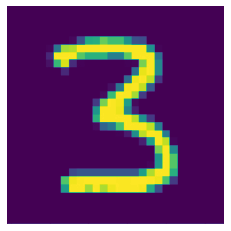

In [38]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('3.jpg', 0).astype(np.float32)
plt.imshow(img)
plt.axis('off')
img = cv2.resize(img, (28,28)).reshape(1, 784)
img = torch.tensor(img).reshape([1, 784])

In [39]:
output = model(img.to(device))

_, preds_tensor = torch.max(output, 1)
pytorchPredictions = np.squeeze(preds_tensor)

c:\Users\nguye\anaconda3\envs\pytor\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [40]:
print('The predict result is', pytorchPredictions.to('cpu').numpy())

The predict result is 3
